Test Accuracy: 0.7016949152542373

Report:
               precision    recall  f1-score   support

           0       0.57      0.70      0.62       105
           1       0.81      0.71      0.75       190

    accuracy                           0.70       295
   macro avg       0.69      0.70      0.69       295
weighted avg       0.72      0.70      0.71       295



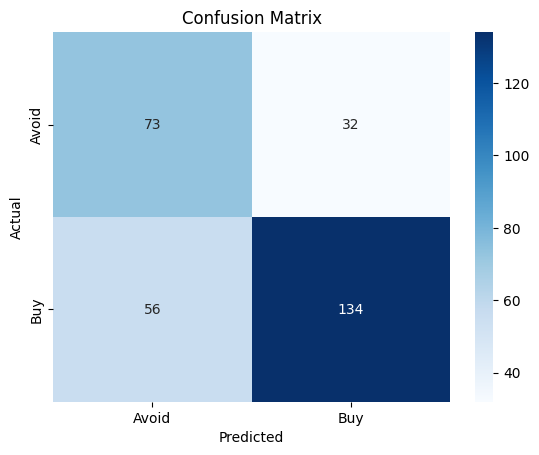

['/Users/davidlawal/Desktop/Investr-/backend/models/recommendation_model.pkl']

In [40]:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean the dataset
df = pd.read_csv("realestate_data_london_2024_nov.csv")
df = df[~df['price'].astype(str).str.contains("POA", na=False)]
df['price'] = df['price'].replace('[£,]', '', regex=True).astype(float)
df.dropna(subset=['price', 'bedrooms', 'bathrooms', 'title'], inplace=True)
df['sizeSqFeetMax'] = df['sizeSqFeetMax'].fillna(df['sizeSqFeetMax'].median())

# Extract region from title
df['postcode'] = df['title'].str.extract(r'([A-Z]{1,2}\d{1,2}[A-Z]?)\s*,?\s*$')
df['postcode_prefix'] = df['postcode'].str.extract(r'^([A-Z]{1,2})')
postcode_to_region = {
    'N': 'North', 'NW': 'North',
    'E': 'East',
    'S': 'South', 'SE': 'South', 'SW': 'South',
    'W': 'West',
    'WC': 'Central', 'EC': 'Central'
}
df['region'] = df['postcode_prefix'].map(postcode_to_region).fillna('Other')

# Add numerical region score
region_score_map = {
    "Central": 0.90,
    "East": 0.85,
    "South": 0.75,
    "West": 0.65,
    "North": 0.60,
    "Other": 0.50
}
df['region_score'] = df['region'].map(region_score_map)

# One-hot encode region (excluding 'region_score')
df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=False)

# Property type encoding
common_types = ['Flat', 'House', 'Detached', 'Semi_Detached', 'Terraced']
df['property_type'] = df['propertyType'].apply(lambda x: x.replace("-", "_") if x.replace("-", "_") in common_types else 'Other')
df = pd.get_dummies(df, columns=['property_type'], prefix='propertyType', drop_first=False)

# Feature engineering (safe features)
df['price_per_bedroom'] = df['price'] / df['bedrooms']
df['price_per_sqft'] = df['price'] / df['sizeSqFeetMax']
df['estimated_rent'] = df['price'] * np.random.uniform(0.0035, 0.0065, size=len(df))
df['rent_to_price_ratio'] = (df['estimated_rent'] * 12) / df['price'] * 100
df['bedrooms_per_100k'] = df['bedrooms'] / (df['price'] / 100_000)

# Growth used for labeling only
df['expected_growth_rate'] = np.random.uniform(0.02, 0.06, size=len(df))
df['roi'] = df['rent_to_price_ratio'] + (df['expected_growth_rate'] * 100)

# Label logic (no leakage)
HIGH_ROI_THRESHOLD = 9.5
HIGH_GROWTH_THRESHOLD = 0.045
df['label'] = ((df['roi'] > HIGH_ROI_THRESHOLD) | (df['expected_growth_rate'] > HIGH_GROWTH_THRESHOLD)).astype(int)

# Final features (no leakage)
target = df['label']
features = df[[
    'price', 'bedrooms', 'bathrooms', 'sizeSqFeetMax',
    'price_per_bedroom', 'price_per_sqft', 'estimated_rent',
    'rent_to_price_ratio', 'bedrooms_per_100k', 'region_score'
] + [col for col in df.columns if col.startswith("propertyType_") or col.startswith("region_") and col != "region_score"]]

# Train/test split + SMOTE
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Train model
base_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, subsample=0.8, random_state=42)
model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Avoid', 'Buy'], yticklabels=['Avoid', 'Buy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save model
joblib.dump(model, "/Users/davidlawal/Desktop/Investr-/backend/models/recommendation_model.pkl")


In [41]:
print(model.feature_names_in_)

['price' 'bedrooms' 'bathrooms' 'sizeSqFeetMax' 'price_per_bedroom'
 'price_per_sqft' 'estimated_rent' 'rent_to_price_ratio'
 'bedrooms_per_100k' 'region_score' 'region_Central' 'region_East'
 'region_North' 'region_Other' 'region_South' 'region_West'
 'propertyType_Detached' 'propertyType_Flat' 'propertyType_House'
 'propertyType_Other' 'propertyType_Semi_Detached' 'propertyType_Terraced']
